In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
import math
from pprint import pprint
import seaborn as sns
import astropy.units as u
from astropy.coordinates import SkyCoord
from scipy.stats import kstest, ks_2samp
%matplotlib inline

In [2]:
def match(catalog_1, catalog_2):
    """
    匹配两个表
    :param catalog_1:
    :param catalog_2:
    :return:
    """
    sdss = SkyCoord(ra=catalog_1.ra*u.degree, dec=catalog_1.dec*u.degree)
    decals = SkyCoord(ra=catalog_2.ra*u.degree, dec=catalog_2.dec*u.degree)
    idx, d2d, d3d = sdss.match_to_catalog_sky(decals)
    max_sep = 4 * 0.262 * u.arcsec
    distance_idx = d2d < max_sep
    sdss_matches = catalog_1.iloc[distance_idx]
    matches = idx[distance_idx]
    decal_matches = catalog_2.iloc[matches]
    test = sdss_matches.loc[:].rename(columns={"ra":"new_ra", "dec":"new_dec"})
    test.insert(0, 'ID', range(len(test)))
    decal_matches.insert(0, 'ID', range(len(decal_matches)))
    new_df = pd.merge(test, decal_matches, how="inner", on=["ID"])
    return new_df.drop("ID", axis=1)
def cal_per(df: pd.DataFrame=None, num=None):
    """
    返回占比
    """
    sum = 0
    if num == None:
        num = [len(df.query("label == 0 or label == '0'")),len(df.query("label == 1 or label == '1'")),
                   len(df.query("label == 2 or label == '2'")),len(df.query("label == 3 or label == '3'")),
                   len(df.query("label == 4 or label == '4'")),len(df.query("label == 5 or label == '5'")),
                   len(df.query("label == 6 or label == '6'"))]
    for i in num:
        sum += i
    return [x/sum for x in num]

In [3]:
"""主星系"""
with fits.open("/data/GZ_Decals/VAGC_MGS-m14_1777--20180116.fits") as hdul:
    ra = np.array(hdul[1].data["RA      "])
    dec = np.array(hdul[1].data["DEC     "])
    petro_mag = np.array(hdul[1].data["PETROMAG"][:, 2])
    z = np.array(hdul[1].data["Z       "])
    MGS = pd.DataFrame(np.array((ra, dec, petro_mag, z)).T, columns=["ra", "dec", "petro_mag", "redshift"])

In [4]:
decals_dataset = pd.read_csv("/data/renhaoye/decals_2022/dataset_decals.csv", index_col=0)  # 训练验证测试集
decals_pred = pd.read_csv("/data/renhaoye/decals_2022/decals_test_prob.csv", index_col=0)  # decals的预测结果
sdss_pred = pd.read_csv("/data/renhaoye/decals_2022/sdss_test_prob.csv", index_col=0)  # sdss的预测结果
out_decals_pred = pd.read_table("/data/renhaoye/decals_2022/out_decals_prob.txt", sep="\s+")
labels = ["merger", "round", "between", "cigar", "edgeOn", "noBar", "strongBar"]

In [5]:
out_decals_pred = match(MGS, out_decals_pred)
out_decals_pred.drop(["new_ra", "new_dec"], axis=1, inplace=True)

In [6]:
decals_df = pd.read_csv("/data/renhaoye/decals_2022/fits.csv", index_col=0)
threshold = 0.5
merger = decals_df.query('merging_minor_disturbance_fraction > %f '
                           '| merging_major_disturbance_fraction > %f '
                           '| merging_merger_fraction > %f ' % (threshold, threshold, threshold))
round = decals_df.query('smooth_or_featured_smooth_fraction >  %f '
                              '& how_rounded_round_fraction > %f' % (threshold, threshold))
between = decals_df.query('smooth_or_featured_smooth_fraction >  %f '
                                '& how_rounded_in_between_fraction > %f' % (threshold, threshold))
cigar = decals_df.query('smooth_or_featured_smooth_fraction > %f '
                                  '& how_rounded_cigar_shaped_fraction > %f' % (threshold, threshold))
edgeOn = decals_df.query('smooth_or_featured_featured_or_disk_fraction > %f '
                       '& disk_edge_on_yes_fraction > %f' % (threshold, threshold))
noBar = decals_df.query('smooth_or_featured_featured_or_disk_fraction > %f '
                          '& disk_edge_on_no_fraction > %f '
                          '& bar_no_fraction > %f ' % (threshold, threshold, threshold))
strongBar = decals_df.query('smooth_or_featured_featured_or_disk_fraction > %f '
                              '& disk_edge_on_no_fraction > %f '
                              '&bar_strong_fraction > %f ' % (threshold, threshold, threshold))
merger.insert(0, "label", 0)
round.insert(0, "label", 1)
between.insert(0, "label", 2)
cigar.insert(0, "label", 3)
edgeOn.insert(0, "label", 4)
noBar.insert(0, "label", 5)
strongBar.insert(0, "label", 6)
decals_50p = match(MGS, pd.concat([merger, round, between, cigar, edgeOn, noBar, strongBar]))

In [ ]:
MGS

In [7]:
def find_max(a):
    idx = a.argmax(axis=1)
    out = np.zeros_like(a,dtype=float)
    out[np.arange(a.shape[0]), idx] = 1
    return out
decals_df_d = decals_df.drop(["iauname", "petro_theta", "petro_th50", "petro_th90",
                              "elpetro_absmag_r", "sersic_nmgy_r", "mag_r", "smooth_or_featured_smooth_concentration",
                              'smooth_or_featured_featured_or_disk_concentration',
                              "disk_edge_on_no_concentration", "disk_edge_on_yes_concentration",
                              'has_spiral_arms_yes_concentration', "has_spiral_arms_no_concentration",
                              "bar_no_concentration", "bar_weak_concentration",
                              "bar_strong_concentration", 'bulge_size_none_concentration',
                              "bulge_size_small_concentration", "bulge_size_dominant_concentration",
                              "bulge_size_large_concentration", "bulge_size_moderate_concentration",
                              "how_rounded_round_concentration",
                              "how_rounded_cigar_shaped_concentration",
                              "how_rounded_in_between_concentration",
                              "edge_on_bulge_none_concentration",
                              "edge_on_bulge_rounded_concentration",
                              "edge_on_bulge_boxy_concentration",
                              "spiral_winding_loose_concentration",
                              "spiral_winding_medium_concentration",
                              "spiral_winding_tight_concentration",
                              "spiral_arm_count_1_concentration", "spiral_arm_count_2_concentration",
                              "spiral_arm_count_3_concentration", "spiral_arm_count_4_concentration",
                              "spiral_arm_count_cant_tell_concentration",
                              "spiral_arm_count_more_than_4_concentration",
                              "merging_none_concentration", "merging_merger_concentration",
                              "merging_major_disturbance_concentration",
                              "merging_minor_disturbance_concentration",
                              "smooth_or_featured_artifact_concentration",
                              "file_loc", "wrong_size_statistic", "wrong_size_warning",
                              "merging_proportion_volunteers_asked",
                              "bar_proportion_volunteers_asked",
                              "spiral_arm_count_proportion_volunteers_asked",
                              "spiral_arm_count_proportion_volunteers_asked",
                              "disk_edge_on_proportion_volunteers_asked",
                              "edge_on_bulge_proportion_volunteers_asked",
                              "bulge_size_proportion_volunteers_asked",
                              "has_spiral_arms_proportion_volunteers_asked",
                              "how_rounded_proportion_volunteers_asked",
                              "smooth_or_featured_proportion_volunteers_asked",
                              "spiral_winding_proportion_volunteers_asked"], axis=1)
head = np.array(decals_df_d[["ra", "dec", "redshift"]])
q1 = find_max(np.array(decals_df_d[["merging_merger_fraction", "merging_major_disturbance_fraction",
                  "merging_minor_disturbance_fraction", "merging_none_fraction"]]))
q2 = find_max(np.array(decals_df_d[["smooth_or_featured_artifact_fraction",
                  "smooth_or_featured_featured_or_disk_fraction",
                  "smooth_or_featured_smooth_fraction"]]))
q3_1 = find_max(np.array(decals_df_d[["how_rounded_round_fraction", 'how_rounded_in_between_fraction',
                    "how_rounded_cigar_shaped_fraction"]]))
q3_2 = find_max(np.array(decals_df_d[["disk_edge_on_yes_fraction", "disk_edge_on_no_fraction"]]))
q4 = find_max(np.array(decals_df_d[["bar_no_fraction", "bar_strong_fraction"]]))
q = np.concatenate((head, q1, q2, q3_1, q3_2, q4), axis=1)
decals_df_max = pd.DataFrame(q,columns=["ra", "dec", "redshift","merging_merger_fraction",
                        "merging_major_disturbance_fraction",
                        "merging_minor_disturbance_fraction", "merging_none_fraction",
                        "smooth_or_featured_artifact_fraction","smooth_or_featured_featured_or_disk_fraction",
                        "smooth_or_featured_smooth_fraction","how_rounded_round_fraction",
                        'how_rounded_in_between_fraction',"how_rounded_cigar_shaped_fraction",
                        "disk_edge_on_yes_fraction", "disk_edge_on_no_fraction","bar_no_fraction",
                        "bar_strong_fraction"])

In [8]:
merger_max = decals_df_max.query('merging_none_fraction != 1')
round_max = decals_df_max.query('smooth_or_featured_smooth_fraction == 1 '
                              '& how_rounded_round_fraction == 1')
between_max = decals_df_max.query('smooth_or_featured_smooth_fraction == 1'
                                '& how_rounded_in_between_fraction == 1')
cigar_max = decals_df_max.query('smooth_or_featured_smooth_fraction == 1'
                                  '& how_rounded_cigar_shaped_fraction == 1')
edgeOn_max = decals_df_max.query('smooth_or_featured_featured_or_disk_fraction == 1'
                       '& disk_edge_on_yes_fraction == 1')
noBar_max = decals_df_max.query('smooth_or_featured_featured_or_disk_fraction == 1'
                          '& disk_edge_on_no_fraction == 1'
                          '& bar_no_fraction == 1')
strongBar_max = decals_df_max.query('smooth_or_featured_featured_or_disk_fraction == 1'
                              '& disk_edge_on_no_fraction == 1'
                              '& bar_strong_fraction == 1')
merger_max.insert(0, "label", 0)
round_max.insert(0, "label", 1)
between_max.insert(0, "label", 2)
cigar_max.insert(0, "label", 3)
edgeOn_max.insert(0, "label", 4)
noBar_max.insert(0, "label", 5)
strongBar_max.insert(0, "label", 6)
decals_50p_max = match(MGS, pd.concat([merger_max, round_max, between_max, cigar_max, edgeOn_max, noBar_max, strongBar_max]))
decals_50p_max.drop(["new_ra", "new_dec"], axis=1, inplace=True)

In [18]:
# decals_right = decals_pred.query("label == pred")
# sdss_right = sdss_pred.query("label == pred")
# decals_wrong = decals_pred.query("label != pred")
# sdss_wrong = sdss_pred.query("label != pred")
# fig = plt.figure(figsize=(20, 15))
# sns.set()
# sns.set_theme(font='Times New Roman',font_scale=1.4, palette=None)
# sns.set_style("white")
# ax = fig.add_subplot(3, 5, 1)
# ax.set_title("all")
# sns.histplot(decals_pred.prob,
#              stat="density", label="DECaLS", bins=50, kde=True, color="r")
# sns.histplot(sdss_pred.prob,
#              stat="density", label="SDSS", bins=50, kde=True)
# ax.set_xlabel(None)
# ax.set_ylabel("all")
# ax.legend(loc="upper left")
# plt.xlim(0, 1)
#
# ax = fig.add_subplot(3, 5, 6)
# sns.histplot(decals_pred.query("label == pred").prob,
#              stat="density", label="decals", bins=50, kde=True, color="r")
# sns.histplot(sdss_pred.query("label == pred").prob,
#              stat="density", label="sdss", bins=50, kde=True)
# ax.set_xlabel(None)
# ax.set_ylabel("right")
# plt.xlim(0, 1)
#
# ax = fig.add_subplot(3, 5, 11)
# sns.histplot(decals_pred.query("label != pred").prob,
#              stat="density", label="decals", bins=50, kde=True, color="r")
# sns.histplot(sdss_pred.query("label != pred").prob,
#              stat="density", label="sdss", bins=50, kde=True)
# ax.set_xlabel("probability")
# ax.set_ylabel("wrong")
# plt.xlim(0, 1)
#
# ax = fig.add_subplot(3, 5, 2)
# ax.set_title("merger")
# sns.histplot(decals_pred.query("label == 0").prob,
#              stat="density", label="decals", bins=50, kde=True, color="r")
# sns.histplot(sdss_pred.query("label == 0").prob,
#              stat="density", label="sdss", bins=50, kde=True)
# ax.set_xlabel(None)
# ax.set_ylabel(None)
# plt.xlim(0, 1)
#
# ax = fig.add_subplot(3, 5, 7)
# sns.histplot(decals_right.query("label == 0").prob,
#              stat="density", label="decals", bins=50, kde=True, color="r")
# sns.histplot(sdss_right.query("label == 0").prob,
#              stat="density", label="sdss", bins=50, kde=True)
# ax.set_xlabel(None)
# ax.set_ylabel(None)
# plt.xlim(0, 1)
#
# ax = fig.add_subplot(3, 5, 12)
# sns.histplot(decals_wrong.query("label == 0").prob,
#              stat="density", label="decals", bins=50, kde=True, color="r")
# sns.histplot(sdss_wrong.query("label == 0").prob,
#              stat="density", label="sdss", bins=50, kde=True)
# ax.set_xlabel("probability")
# ax.set_ylabel(None)
# plt.xlim(0, 1)
#
# ax = fig.add_subplot(3, 5, 3)
# ax.set_title("elliptical")
# sns.histplot(decals_pred.query("label == 1 or label == 2 or label == 3").prob,
#              stat="density", label="decals", bins=50, kde=True, color="r")
# sns.histplot(sdss_pred.query("label == 1 or label == 2 or label == 3").prob,
#              stat="density", label="sdss", bins=50, kde=True)
# ax.set_xlabel(None)
# ax.set_ylabel(None)
# plt.xlim(0, 1)
#
# ax = fig.add_subplot(3, 5, 8)
# sns.histplot(decals_right.query("label == 1 or label == 2 or label == 3").prob,
#              stat="density", label="decals", bins=50, kde=True, color="r")
# sns.histplot(sdss_right.query("label == 1 or label == 2 or label == 3").prob,
#              stat="density", label="sdss", bins=50, kde=True)
# ax.set_xlabel(None)
# ax.set_ylabel(None)
# plt.xlim(0, 1)
#
# ax = fig.add_subplot(3, 5, 13)
# sns.histplot(decals_wrong.query("label == 1 or label == 2 or label == 3").prob,
#              stat="density", label="decals", bins=50, kde=True, color="r")
# sns.histplot(sdss_wrong.query("label == 1 or label == 2 or label == 3").prob,
#              stat="density", label="sdss", bins=50, kde=True)
# ax.set_xlabel("probability")
# ax.set_ylabel(None)
# plt.xlim(0, 1)
#
# ax = fig.add_subplot(3, 5, 4)
# ax.set_title("edgeOn")
# sns.histplot(decals_pred.query("label == 4").prob,
#              stat="density", label="decals", bins=50, kde=True, color="r")
# sns.histplot(sdss_pred.query("label == 4").prob,
#              stat="density", label="sdss", bins=50, kde=True)
# ax.set_xlabel(None)
# ax.set_ylabel(None)
# plt.xlim(0, 1)
#
# ax = fig.add_subplot(3, 5, 9)
# sns.histplot(decals_right.query("label == 4").prob,
#              stat="density", label="decals", bins=50, kde=True, color="r")
# sns.histplot(sdss_right.query("label == 4").prob,
#              stat="density", label="sdss", bins=50, kde=True)
# ax.set_xlabel(None)
# ax.set_ylabel(None)
# plt.xlim(0, 1)
#
# ax = fig.add_subplot(3, 5, 14)
# sns.histplot(decals_wrong.query("label == 4").prob,
#              stat="density", label="decals", bins=50, kde=True, color="r")
# sns.histplot(sdss_wrong.query("label == 4").prob,
#              stat="density", label="sdss", bins=50, kde=True)
# ax.set_xlabel("probability")
# ax.set_ylabel(None)
# plt.xlim(0, 1)
#
# ax = fig.add_subplot(3, 5, 5)
# ax.set_title("disk")
# sns.histplot(decals_pred.query("label == 5 or label == 6").prob,
#              stat="density", label="decals", bins=50, kde=True, color="r")
# sns.histplot(sdss_pred.query("label == 5 or label == 6").prob,
#              stat="density", label="sdss", bins=50, kde=True)
# ax.set_xlabel(None)
# ax.set_ylabel(None)
# plt.xlim(0, 1)
#
# ax = fig.add_subplot(3, 5, 10)
# sns.histplot(decals_right.query("label == 5 or label == 6").prob,
#              stat="density", label="decals", bins=50, kde=True, color="r")
# sns.histplot(sdss_right.query("label == 5 or label == 6").prob,
#              stat="density", label="sdss", bins=50, kde=True)
# ax.set_xlabel(None)
# ax.set_ylabel(None)
# plt.xlim(0, 1)
#
# ax = fig.add_subplot(3, 5, 15)
# sns.histplot(decals_wrong.query("label == 5 or label == 6").prob,
#              stat="density", label="decals", bins=50, kde=True, color="r")
# sns.histplot(sdss_wrong.query("label == 5 or label == 6").prob,
#              stat="density", label="sdss", bins=50, kde=True)
# ax.set_xlabel("probability")
# ax.set_ylabel(None)
# plt.xlim(0, 1)
# plt.tight_layout()
# plt.show()

In [19]:
# fig = plt.figure(figsize=(20, 10))
# sns.set()
# sns.set_theme(font='Times New Roman',font_scale=1, palette=None)
# sns.set_style("whitegrid")
# plt.subplot(331)
# plt.title("all")
# sns.histplot(out_decals_pred.query("redshift > 0.075 and redshift < 0.15 and petro_mag < 17.77").prob, stat="percent", label="DECaLS", bins=50, kde=True)
# for i in range(7):
#     plt.subplot(3, 3, i + 2)
#     plt.title(i)
#     sns.histplot(out_decals_pred.query("redshift > 0.075 and redshift < 0.15 and petro_mag < 17.77 and label == %d" % i).prob, stat="percent", label="DECaLS", bins=50, kde=True)
#     plt.xlim(0, 1)
#     plt.xticks(np.arange(0, 1.001, 0.1))
# plt.tight_layout()
# plt.show()

In [9]:
in_z = np.array(decals_50p.query("redshift_x < 0.15 and redshift_x > 0.001 and petro_mag<17.77").redshift_x)
out_z = np.array(out_decals_pred.query("redshift < 0.15 and redshift > 0.001 and petro_mag<17.77").redshift)
in_mag = np.array(decals_50p.query("redshift_x < 0.15 and redshift_x > 0.001 and petro_mag<17.77").petro_mag)
out_mag = np.array(out_decals_pred.query("redshift < 0.15 and redshift > 0.001 and petro_mag<17.77").petro_mag)

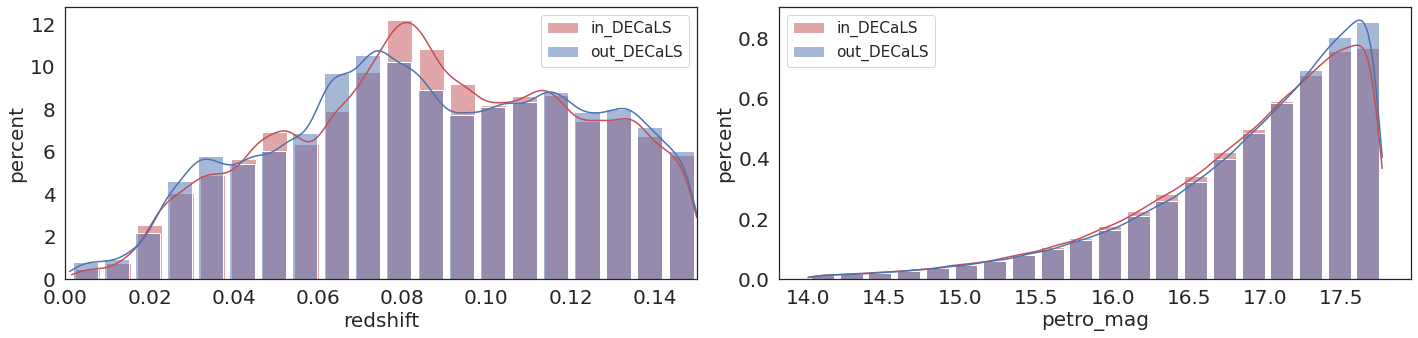

In [21]:
plt.figure(figsize=(20, 5))
plt.subplot(121)
sns.set()
sns.set_theme(font='Times New Roman',font_scale=1.4, palette=None)
sns.set_style("white")
sns.histplot(in_z, stat="density", bins=20, shrink=0.8, kde=True, color="r", label="in_DECaLS")
sns.histplot(out_z,stat="density", bins=20, shrink=0.8, kde=True, label="out_DECaLS")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("redshift", fontsize=20)
plt.ylabel("percent", fontsize=20)
plt.legend()
plt.xlim((0, 0.15))

plt.subplot(122)
sns.histplot(in_mag, stat="density", bins=20, shrink=0.8, kde=True, color="r", label="in_DECaLS")
sns.histplot(out_mag, stat="density", bins=20, shrink=0.8, kde=True, label="out_DECaLS")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("petro_mag", fontsize=20)
plt.ylabel("percent", fontsize=20)
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
# .pvalue>0.05
print(ks_2samp(out_z, in_z))
print(ks_2samp(in_mag, out_mag))

KstestResult(statistic=0.03034494454004677, pvalue=1.0215006437654696e-99)
KstestResult(statistic=0.027782691310320407, pvalue=1.1784449682270035e-83)


In [12]:
from sklearn.utils import shuffle
in_test = decals_50p_max.query("redshift_x < 0.15 and redshift_x > 0.001 and petro_mag<17.77").copy()
in_test = in_test.rename(columns={"redshift_x": "redshift"})
out_test = out_decals_pred.query("redshift < 0.15 and redshift > 0.001 and petro_mag<17.77").copy()
def cut(in_test, out_test, target, bins=20):
    bin = []
    if target=="redshift":
        step = 0.15 / bins
        for i in range(bins):
            if i == 0:
                bin.append([0.001, 0.001+(i+1)*step])
            else:
                bin.append([0.001+i*step, 0.001+(i+1)*step])
    elif target == "petro_mag":
        step = 3.77 / bins
        for i in range(bins):
            if i == 0:
                bin.append([14, 14+(i+1)*step])
            else:
                bin.append([14+i*step, 14+(i+1)*step])
    def cut(in_test, out_test, bin):
        df_in = pd.DataFrame(columns=in_test.columns)
        df_out = pd.DataFrame(columns=out_test.columns)
        for i in range(len(bin)):
            bin_1 = in_test.query("%s > %f and %s < %f" %(target, bin[i][0], target, bin[i][1]))
            bin_2 = out_test.query("%s > %f and %s < %f" %(target, bin[i][0], target, bin[i][1]))
            if len(bin_1) < len(bin_2):
                frac = len(bin_1)/len(bin_2)
                bin_2 = bin_2.sample(frac=frac)
                df_in = pd.concat([df_in, bin_1])
                df_out = pd.concat([df_out, bin_2])
            else:
                frac = len(bin_2)/len(bin_1)
                bin_1 = bin_1.sample(frac=frac)
                df_in = pd.concat([df_in, bin_1])
                df_out = pd.concat([df_out, bin_2])
        return df_in.reset_index(drop=True), df_out.reset_index(drop=True)
    return cut(in_test, out_test, bin)
t1, t2 = cut(in_test, out_test, "petro_mag", bins=30)
t1, t2 = cut(t1, t2, "redshift", bins=40)

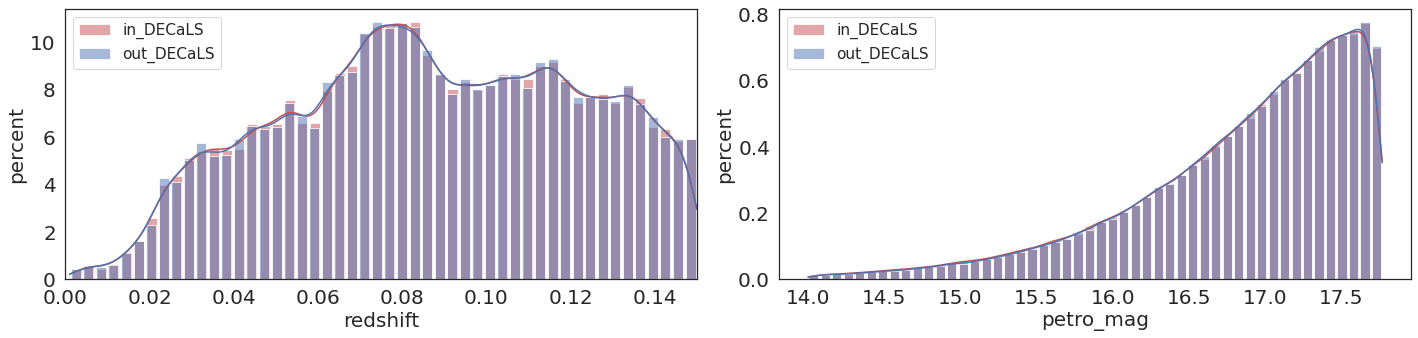

In [25]:
plt.figure(figsize=(20, 5))
plt.subplot(121)
sns.set()
sns.set_theme(font='Times New Roman',font_scale=1.4, palette=None)
sns.set_style("white")
sns.histplot(t1.redshift, stat="density", bins=50, shrink=0.8, kde=True, color="r", label="in_DECaLS")
sns.histplot(t2.redshift,stat="density", bins=50, shrink=0.8, kde=True, label="out_DECaLS")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("redshift", fontsize=20)
plt.ylabel("percent", fontsize=20)
plt.legend()
plt.xlim((0, 0.15))

plt.subplot(122)
sns.histplot(t1.petro_mag, stat="density", bins=50, shrink=0.8, kde=True, color="r", label="in_DECaLS")
sns.histplot(t2.petro_mag, stat="density", bins=50, shrink=0.8, kde=True, label="out_DECaLS")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("petro_mag", fontsize=20)
plt.ylabel("percent", fontsize=20)
plt.legend()
plt.tight_layout()
plt.show()

In [26]:
# .pvalue>0.05
print(ks_2samp(t1.redshift, t2.redshift))
print(ks_2samp(t1.petro_mag, t2.petro_mag))

KstestResult(statistic=0.001492909736055259, pvalue=0.9544216653340818)
KstestResult(statistic=0.005125797733991411, pvalue=0.003994696126118883)


In [27]:
def show(rg, ax, catalog_1, catalog_2, label_1, label_2, prob):
    l, r = rg
    if l <0.001:
        l = 0.001
    try:
        catalog_1 = catalog_1.query("petro_mag < 17.77 and redshift < %f and redshift > %f" % (r,l))
        catalog_2 = catalog_2.query("petro_mag < 17.77 and redshift < %f and redshift > %f and prob > %f" % (r, l, prob))
    except:
        catalog_1 = catalog_1.query("petro_mag < 17.77 and redshift_x < %f and redshift_x > %f" % (r,l))
        catalog_2 = catalog_2.query("petro_mag < 17.77 and redshift < %f and redshift > %f and prob > %f" % (r, l, prob))
    percent_1, percent_2 = cal_per(catalog_1), cal_per(catalog_2)
    width = 0.4
    x = np.arange(len(labels))
    ax.bar(x - width/2, percent_1, width, label=label_1)
    ax.bar(x + width/2, percent_2, width, label=label_2)
    ax.set_xticks(x)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

In [28]:
def cal_error(num, sum, k=3):
    return k * (math.sqrt((math.sqrt(num)/sum)**2 + (num*math.sqrt(sum)/(sum*sum))**2))
    # return k * math.sqrt(num)
    # return [num - k * math.sqrt(num), num + k * math.sqrt(num)]

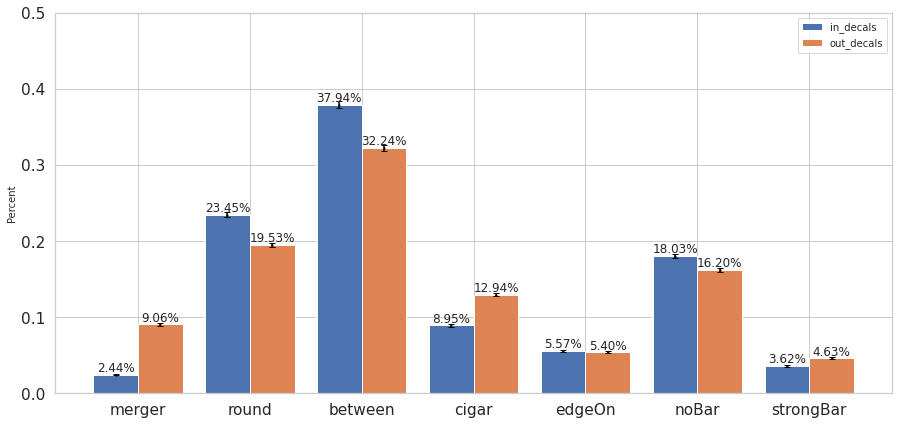

In [29]:
prob = 0.5001
k = 3
ll, rr = 0.001, 0.15
percent_in_decals = cal_per(decals_50p_max.query('redshift_x > %f and redshift_x < %f and petro_mag < 17.77' %(ll, rr)))
percent_out_decals = cal_per(out_decals_pred.query('redshift > %f and redshift < %f and prob > %f  and petro_mag < 17.77' % (ll, rr, prob)))
width = 0.4
sns.set_style("whitegrid")
x = np.arange(len(labels))
fig, ax = plt.subplots(figsize=(15, 7))
ax.bar(x - width/2, percent_in_decals, width, label='in_decals')
ax.bar(x + width/2, percent_out_decals, width, label='out_decals')
ax.set_ylabel('Percent', fontsize=10)
ax.set_xticks(x)
ax.set_xticklabels(labels)
for a,b in zip(x, percent_in_decals): ##控制标签位置
    plt.text(a-width/2,b,'%.2f%%'% (b * 100),ha = 'center',va = 'bottom',fontsize=12)
    sum = len(decals_50p_max.query('redshift_x > %f and redshift_x < %f and petro_mag < 17.77' %(ll, rr)))
    l_s = len(decals_50p_max.query('redshift_x > %f and redshift_x < %f and petro_mag < 17.77 and label == %d' % (ll, rr, a)))
    temp = cal_error(l_s, sum, 3)
    y_error = [[b] if (b - temp) < 0 else [temp], [temp]]
    plt.errorbar(x=a-width/2, y=b, yerr=y_error,
                 color="black", capsize=3,linestyle="None", marker="s",
                 markersize=1, mfc="black", mec="black")
for a,b in zip(x, percent_out_decals): ##控制标签位置
    plt.text(a+width/2,b,'%.2f%%'% (b * 100),ha = 'center',va = 'bottom',fontsize=12)
    sum = len(out_decals_pred.query('redshift > %f and redshift < %f and petro_mag < 17.77' %(ll, rr)))
    l_s = len(out_decals_pred.query('redshift > %f and redshift < %f and petro_mag < 17.77 and label == %d and prob > %f' % (ll, rr, a, prob)))
    temp = cal_error(l_s, sum, 3)
    y_error = [[b] if (b - temp) < 0 else [temp], [temp]]
    plt.errorbar(x=a+width/2, y=b, yerr=y_error,
                 color="black", capsize=3,linestyle="None", marker="s",
                 markersize=1, mfc="black", mec="black")
ax.legend(fontsize=10)
# plt.title(prob)
plt.ylim(0, 0.5)
plt.savefig("/data/renhaoye/decals_2022/code/plt/类别占比对比80.png", dpi=300)
plt.show()

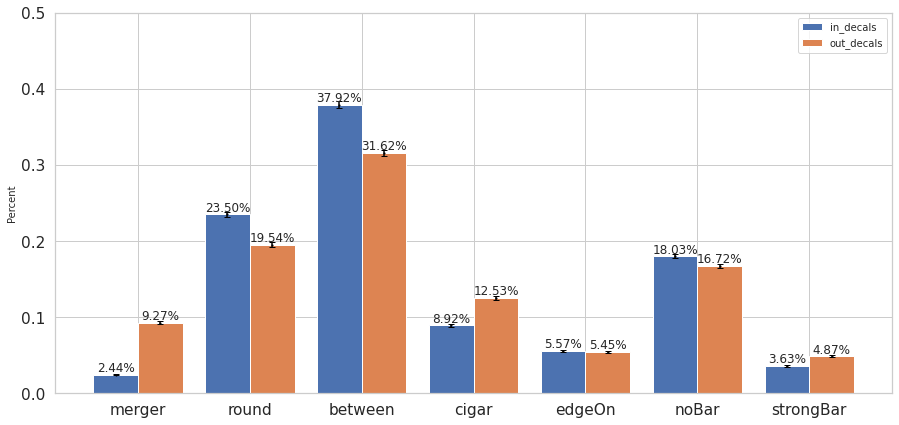

In [30]:
prob = 0.5001
k = 3
ll, rr = 0.001, 0.15
# percent_in_decals = cal_per(decals_50p_max.query('redshift_x > %f and redshift_x < %f and petro_mag < 17.77' %(ll, rr)))
# percent_out_decals = cal_per(out_decals_pred.query('redshift > %f and redshift < %f and prob > %f  and petro_mag < 17.77' % (ll, rr, prob)))
percent_in_decals = cal_per(t1)
percent_out_decals = cal_per(t2.query('prob > %f' % (prob)))
width = 0.4
sns.set_style("whitegrid")
x = np.arange(len(labels))
fig, ax = plt.subplots(figsize=(15, 7))
ax.bar(x - width/2, percent_in_decals, width, label='in_decals')
ax.bar(x + width/2, percent_out_decals, width, label='out_decals')
ax.set_ylabel('Percent', fontsize=10)
ax.set_xticks(x)
ax.set_xticklabels(labels)
for a,b in zip(x, percent_in_decals): ##控制标签位置
    plt.text(a-width/2,b,'%.2f%%'% (b * 100),ha = 'center',va = 'bottom',fontsize=12)
    sum = len(t1.query('redshift > %f and redshift < %f and petro_mag < 17.77' %(ll, rr)))
    l_s = len(t1.query('redshift > %f and redshift < %f and petro_mag < 17.77 and label == %d' % (ll, rr, a)))
    temp = cal_error(l_s, sum, 3)
    y_error = [[b] if (b - temp) < 0 else [temp], [temp]]
    plt.errorbar(x=a-width/2, y=b, yerr=y_error,
                 color="black", capsize=3,linestyle="None", marker="s",
                 markersize=1, mfc="black", mec="black")
for a,b in zip(x, percent_out_decals): ##控制标签位置
    plt.text(a+width/2,b,'%.2f%%'% (b * 100),ha = 'center',va = 'bottom',fontsize=12)
    sum = len(t2.query('redshift > %f and redshift < %f and petro_mag < 17.77' %(ll, rr)))
    l_s = len(t2.query('redshift > %f and redshift < %f and petro_mag < 17.77 and label == %d and prob > %f' % (ll, rr, a, prob)))
    temp = cal_error(l_s, sum, 3)
    y_error = [[b] if (b - temp) < 0 else [temp], [temp]]
    plt.errorbar(x=a+width/2, y=b, yerr=y_error,
                 color="black", capsize=3,linestyle="None", marker="s",
                 markersize=1, mfc="black", mec="black")
ax.legend(fontsize=10)
# plt.title(prob)
plt.ylim(0, 0.5)
plt.savefig("/data/renhaoye/decals_2022/code/plt/类别占比对比80.png", dpi=300)
plt.show()

In [14]:
test = pd.read_table("/data/renhaoye/decals_2022/out_decals_prob7.txt", sep="\s+")
test = match(MGS, test)
test.drop(["new_ra", "new_dec"], axis=1, inplace=True)
probs = test.drop(["loc"], axis=1).query("redshift > 0.001 and redshift < 0.15 and petro_mag < 17.77")

In [32]:
# merger_out = probs.query("label == 0")
# round_out = probs.query("label == 1")
# between_out = probs.query("label == 2")
# cigar_out = probs.query("label == 3")
# edgeOn_out = probs.query("label == 4")
# noBar_out = probs.query("label == 5")
# strongBar_out = probs.query("label == 6")

In [33]:
prob7 = np.array(probs[["prob_0", "prob_1", "prob_2", "prob_3", "prob_4", "prob_5", "prob_6"]].dropna(axis=0, how="any"))
prob7_sum = np.sum(prob7, axis=0, keepdims=True)
label_sum = np.sum(prob7_sum, axis=1)

[ 5770 55558 89655 21100 13161 42627  8580] 236451 [27603 54576 90309 36693 15379 48505 13845] 286910
merger 0.10%
round 0.33%
between 0.45%
cigar 0.19%
edgeOn 0.15%
noBar 0.28%
strongBar 0.12%

merger 0.18%
round 0.27%
between 0.36%
cigar 0.21%
edgeOn 0.13%
noBar 0.25%
strongBar 0.13%


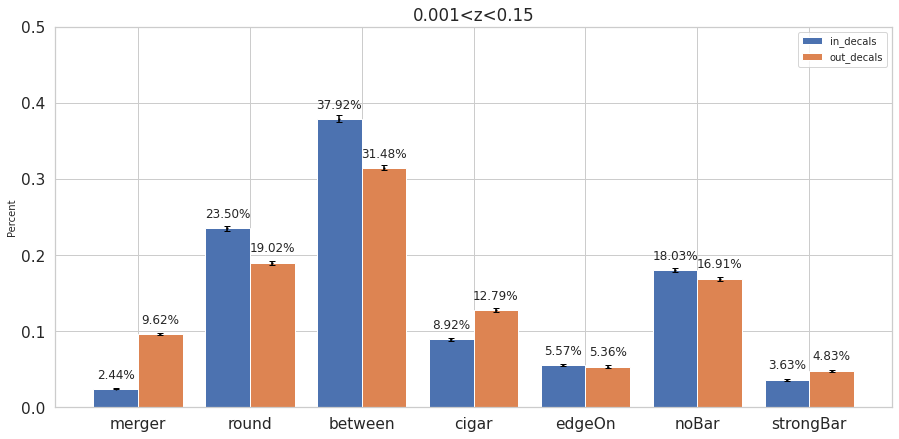

In [86]:
# here1 = t1.copy()
# here2 = probs.copy()
# ll, rr = 0.001, 0.15
# # ll, rr = 0.001, 0.05
# # ll, rr = 0.05, 0.1
# # ll, rr = 0.1, 0.15
# here1 = here1.query("redshift > %f and redshift < %f and petro_mag < 17.77" % (ll, rr))
# here2 = here2.query("redshift > %f and redshift < %f and petro_mag < 17.77" % (ll, rr))
# in_sum = np.array((len(here1.query("label == 0")), len(here1.query("label == 1")), len(here1.query("label == 2")), len(here1.query("label == 3")), len(here1.query("label == 4")), len(here1.query("label == 5")), len(here1.query("label == 6"))))
# out_sum = np.array((len(here2.query("label == 0")), len(here2.query("label == 1")), len(here2.query("label == 2")), len(here2.query("label == 3")), len(here2.query("label == 4")), len(here2.query("label == 5")), len(here2.query("label == 6"))))
# # in_sum[[0, ]] = 0
# # out_sum[[0, ]] = 0
# in_sum_p = cal_per(num=list(in_sum))
# out_sum_p = cal_per(num=list(out_sum))
# width = 0.4
# sns.set_style("whitegrid")
# x = np.arange(len(in_sum_p))
# print(in_sum, in_sum.sum(), out_sum, out_sum.sum())
# fig, ax = plt.subplots(figsize=(15, 7))
# ax.bar(x - width/2, in_sum_p, width, label='in_decals')
# ax.bar(x + width/2, out_sum_p, width, label='out_decals')
# ax.set_ylabel('Percent', fontsize=10)
# ax.set_xticks(x)
# ax.set_xticklabels(labels)
# for a,b in zip(x, in_sum_p): ##控制标签位置
#     plt.text(a-width/2, b + 0.01, '%.2f%%' % (b * 100), ha='center', va='bottom', fontsize=12)
#     if b !=0 :
#         sum = in_sum.sum()
#         l_s = len(here1.query('label == %d' % a))
#         temp = cal_error(l_s, sum, 3)
#         print(labels[a], '%.2f%%' % (temp * 100))
#         y_error = [[b] if (b - temp) < 0 else [temp], [temp]]
#         plt.errorbar(x=a-width/2, y=b, yerr=y_error,
#                      color="black", capsize=3,linestyle="None", marker="s",
#                      markersize=1, mfc="black", mec="black")
# print()
# for a,b in zip(x, out_sum_p): ##控制标签位置
#     plt.text(a+width/2, b + 0.01,'%.2f%%'% (b * 100),ha = 'center',va = 'bottom',fontsize=12)
#     if b !=0 :
#         sum = out_sum.sum()
#         l_s = len(here2.query('redshift > %f and redshift < %f and petro_mag < 17.77 and label == %d and prob > %f' % (0.001, 0.15, a, 0.0001)))
#         temp = cal_error(l_s, sum, 3)
#         print(labels[a], '%.2f%%' % (temp * 100))
#         y_error = [[b] if (b - temp) < 0 else [temp], [temp]]
#         plt.errorbar(x=a+width/2, y=b, yerr=y_error,
#                      color="black", capsize=3,linestyle="None", marker="s",
#                      markersize=1, mfc="black", mec="black")
# ax.legend(fontsize=10)
# plt.show()

In [35]:
import pickle
with open("/data/renhaoye/decals_2022/trained_model/x_ception-LR_0.0001-LS_focal_loss-CLS_7-BSZ_32-OPT_AdamW-BEST_2/cfm/epoch_5_test.dat", "rb") as r:
    data = pickle.load(r)

In [44]:
def display(data, out_s):
    a = []
    for i in range(7):
        b = []
        deleted = np.delete(data, obj=i, axis=1)
        out_s_copy = out_s.copy()
        poped = out_s_copy.pop(i)
        focus = data[:, i]
        for j in range(6):
            b.append(((deleted[i, j] / deleted[:, j].sum()) * out_s_copy[j]))
        a.append(np.array(b).sum() + poped - (1 - (focus[i]/focus.sum())) * out_s[i])
    return np.array(a)
out_s = [27603, 54576, 90309, 36693, 15379, 48505, 13845]
xyz = display(data, out_s)
print(xyz.astype(int))

[21678 54148 90552 35885 16776 53853 14015]


[166313  13161  42627   8580] 230681 [171832  15739  48129  12522] 248222
elliptical 0.70%
edgeOn 0.15%
noBar 0.29%
strongBar 0.12%

elliptical 0.65%
edgeOn 0.16%
noBar 0.29%
strongBar 0.14%


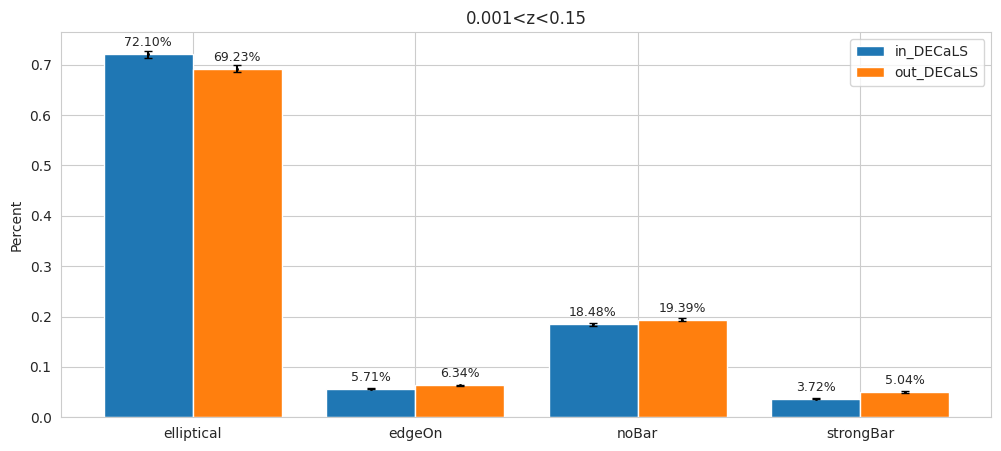

In [298]:
here1 = t1.copy()
here2 = probs.copy()
ll, rr = 0.001, 0.15
# ll, rr = 0.001, 0.05
# ll, rr = 0.05, 0.10
# ll, rr = 0.1, 0.15
# ll, rr = 0.025, 0.075
here1 = here1.query("redshift > %f and redshift < %f and petro_mag < 17.77" % (ll, rr))
here2 = here2.query("redshift > %f and redshift < %f and petro_mag < 17.77 and prob > 0.5001" % (ll, rr))
in_sum = np.array((len(here1.query("label == 0")), len(here1.query("label == 1")), len(here1.query("label == 2")), len(here1.query("label == 3")), len(here1.query("label == 4")), len(here1.query("label == 5")), len(here1.query("label == 6"))))
out_sum = np.array((len(here2.query("label == 0")), len(here2.query("label == 1")), len(here2.query("label == 2")), len(here2.query("label == 3")), len(here2.query("label == 4")), len(here2.query("label == 5")), len(here2.query("label == 6"))))
# out_sum = match_num(prob7_sum[0], out_sum)
out_sum = display(data, list(out_sum))
# in_sum[[0]] = 0
# out_sum[[0]] = 0
# in_sum = np.array([0,55558+89655+21100, 0, 0,13161,42627, 8580])
# out_sum = np.array([0,51748+86302+33782, 0, 0, 15739, 48129, 12522])
in_sum = np.array([55558+89655+21100,13161,42627, 8580])
out_sum = np.array([51748+86302+33782, 15739, 48129, 12522])
labels=["elliptical", "edgeOn", "noBar", "strongBar"]
# temp_1 = in_sum[]
in_sum_p = cal_per(num=list(in_sum))
out_sum_p = cal_per(num=list(out_sum))
width = 0.4
sns.set_style("whitegrid")
x = np.arange(len(in_sum_p))
print(in_sum, in_sum.sum(), out_sum, out_sum.sum())
fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(x - width/2, in_sum_p, width, label='in_DECaLS')
ax.bar(x + width/2, out_sum_p, width, label='out_DECaLS')
ax.set_ylabel('Percent', fontsize=10)
ax.set_xticks(x)
ax.set_xticklabels(labels)
for a,b in zip(x, in_sum_p): ##控制标签位置
    plt.text(a-width/2, b + 0.01, '%.2f%%' % (b * 100), ha='center', va='bottom', fontsize=9)
    if b !=0 :
        sum = in_sum.sum()
        l_s = in_sum[a]
        temp = cal_error(l_s, sum, 3)
        print(labels[a], '%.2f%%' % (temp * 100))
        y_error = [[b] if (b - temp) < 0 else [temp], [temp]]
        plt.errorbar(x=a-width/2, y=b, yerr=y_error,
                     color="black", capsize=3,linestyle="None", marker="s",
                     markersize=1, mfc="black", mec="black")
print()
for a,b in zip(x, out_sum_p): ##控制标签位置
    plt.text(a+width/2, b + 0.01,'%.2f%%'% (b * 100),ha = 'center',va = 'bottom',fontsize=9)
    if b !=0 :
        sum = out_sum.sum()
        l_s = out_sum[a]
        temp = cal_error(l_s, sum, 3)
        print(labels[a], '%.2f%%' % (temp * 100))
        y_error = [[b] if (b - temp) < 0 else [temp], [temp]]
        plt.errorbar(x=a+width/2, y=b, yerr=y_error,
                     color="black", capsize=3,linestyle="None", marker="s",
                     markersize=1, mfc="black", mec="black")
ax.legend(fontsize=10)
plt.title(str(ll)+"<z<"+str(rr))
# plt.ylim((0,0.45))
plt.show()

In [13]:
here1 = t1.copy()
here2 = probs.copy()

NameError: name 'probs' is not defined

In [10]:
sc = SkyCoord(ra=here1.ra*u.degree, dec=here1.dec*u.degree)
sc2 = SkyCoord(ra=here2.ra*u.degree, dec=here2.dec*u.degree)
plt.figure(figsize=(10, 10))
plt.subplot(211, projection="aitoff")
plt.scatter(sc.ra.wrap_at(180*u.deg).radian, sc.dec.radian, marker=".", s=0.1)
plt.subplot(212, projection="aitoff")
plt.scatter(sc2.ra.wrap_at(180*u.deg).radian, sc2.dec.radian, marker=".", s=0.1)
plt.show()

NameError: name 'here1' is not defined

In [289]:
def transf_galactic(df):
    sc = SkyCoord(ra=df.ra*u.degree, dec=df.dec*u.degree, unit="deg")
    lb = np.array((np.array(sc.galactic.l.wrap_at(180*u.deg).radian), np.array(sc.galactic.b.radian)))
    return pd.DataFrame(lb.T, columns=["l", "b"])

In [290]:
# .query("label == 0")
lb_in = transf_galactic(here1.query("label == 0"))
lb_out = transf_galactic(here2.query("label == 0"))

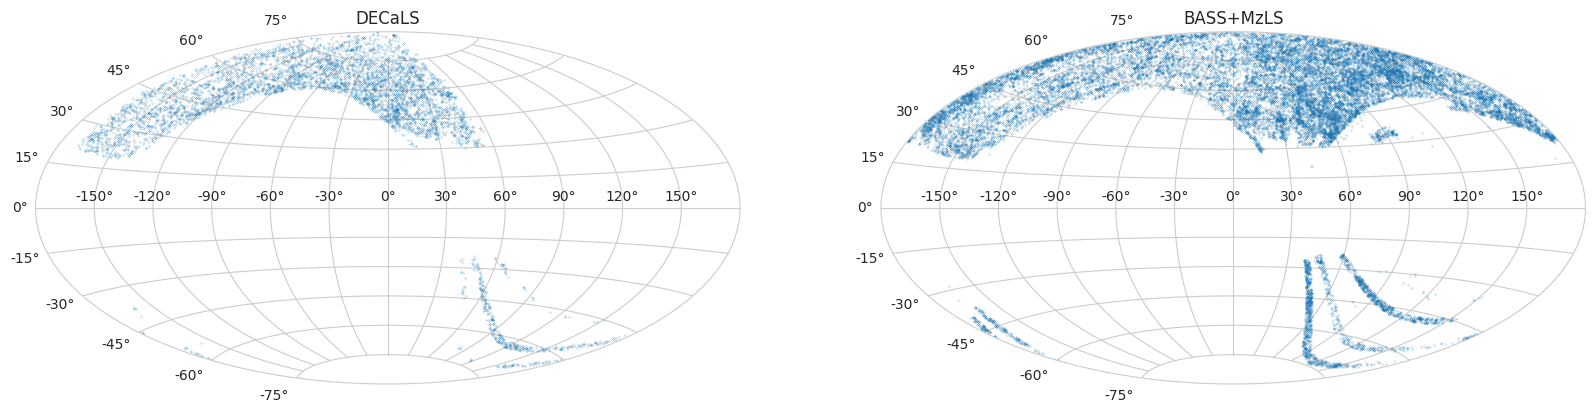

In [291]:
plt.figure(figsize=(20, 10))
plt.subplot(121, projection="aitoff")
plt.title("DECaLS")
plt.scatter(lb_in.l, lb_in.b, marker=".", s=0.1)
plt.subplot(122, projection="aitoff")
plt.title("BASS+MzLS")
plt.scatter(lb_out.l, lb_out.b, marker=".", s=0.1)
plt.show()

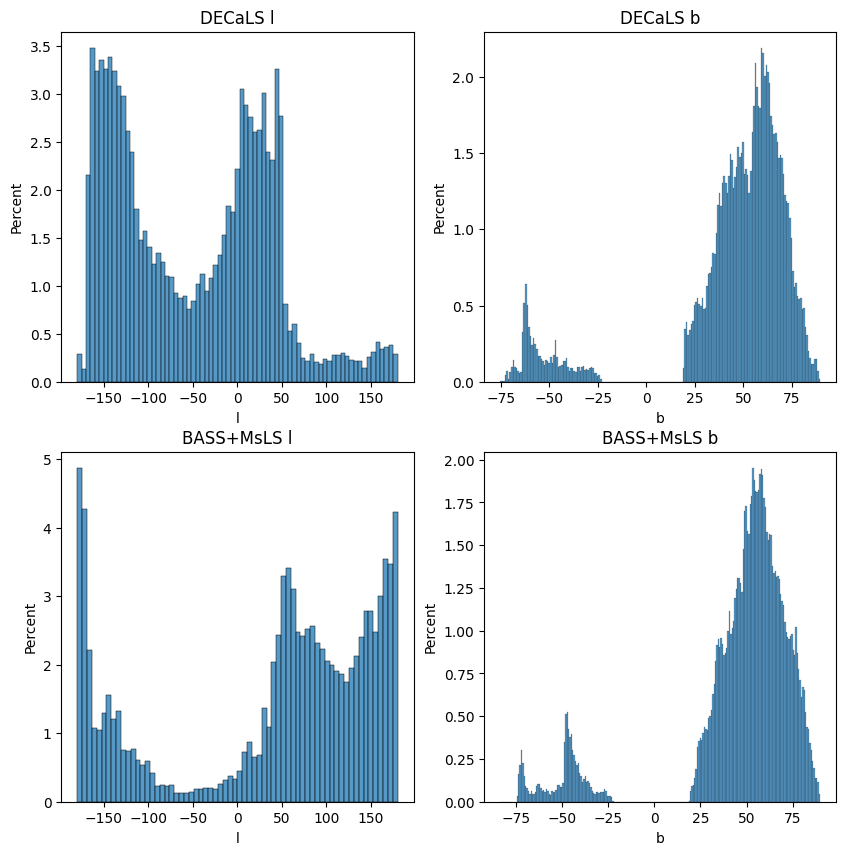

In [266]:
plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.title("DECaLS l")
sns.histplot(lb_in.l, stat="percent")
plt.subplot(222)
plt.title("DECaLS b")
sns.histplot(lb_in.b, stat="percent")

plt.subplot(223)
plt.title("BASS+MsLS l")
sns.histplot(lb_out.l, stat="percent")
plt.subplot(224)
plt.title("BASS+MsLS b")
sns.histplot(lb_out.b, stat="percent")
plt.show()

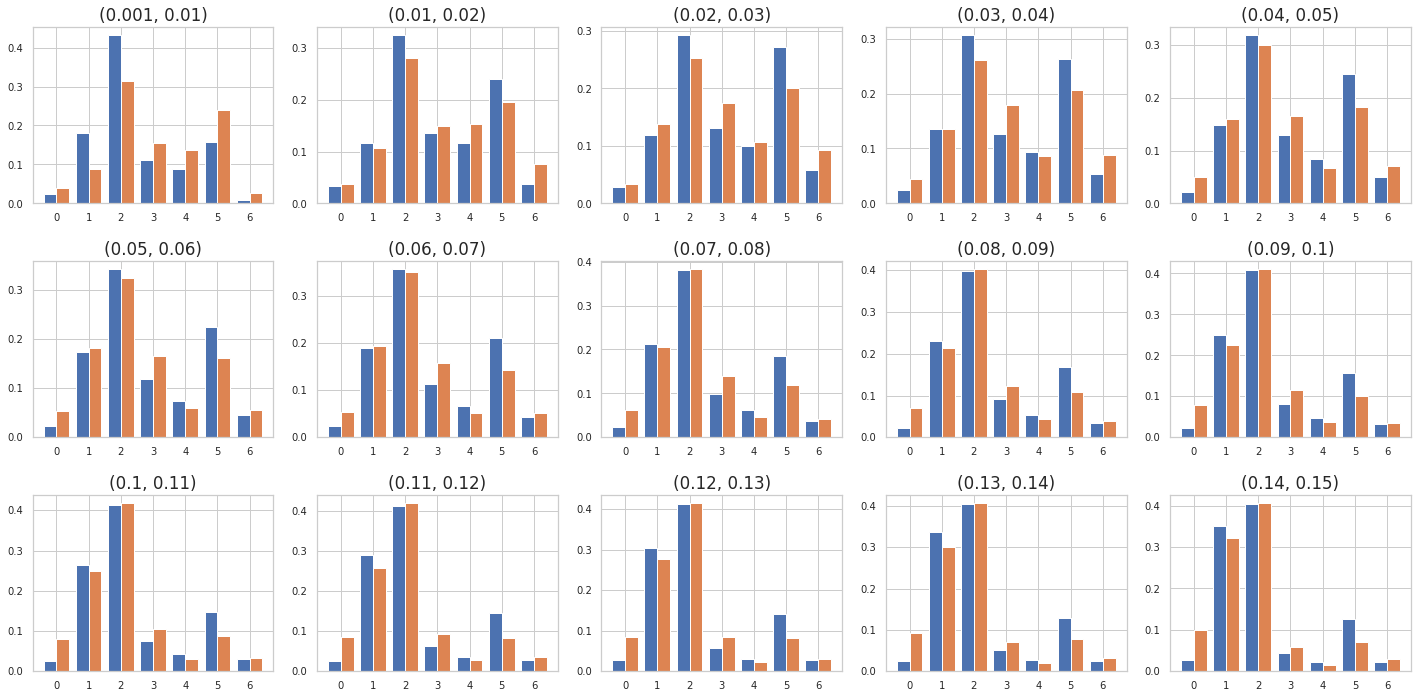

In [37]:
plt.figure(figsize=(20, 10))
for i in range(15):
    ax = plt.subplot(3, 5, i+1)
    if i == 0:
        ax.set_title((0.001, (i+1)*0.01))
    else:
        ax.set_title((i*0.01, (i+1)*0.01))
    show((i*0.01, (i+1)*0.01), ax, decals_50p_max, out_decals_pred, "in_DECaLS", "out_DECaLS", prob=0.8001)
plt.tight_layout()
plt.show()

In [38]:
def load_img(file):
    """
    加载图像，dat和fits均支持，不过仅支持CxHxW
    :param filename: 传入文件名，应当为CHW
    :return: 返回CHW的ndarray
    """
    if ".fits" in file:
        with fits.open(file) as hdul:
            return hdul[0].data.astype(np.float32)
    else:
        raise TypeError
def chw2hwc(img):
    ch1, ch2, ch3 = img[0], img[1], img[2]
    h, w = ch1.shape
    return np.concatenate((ch1.reshape(h, w, 1), ch2.reshape(h, w, 1), ch3.reshape(h, w, 1)), axis=2)

In [39]:
DATA_PATH = "/data/renhaoye/decals_2022/out_decals/scaled/"
with open("/data/renhaoye/decals_2022/out_decals_prob.txt", "r") as r:
    input = r.readlines()[1:]
    input = [x.split(" ") for x in input]

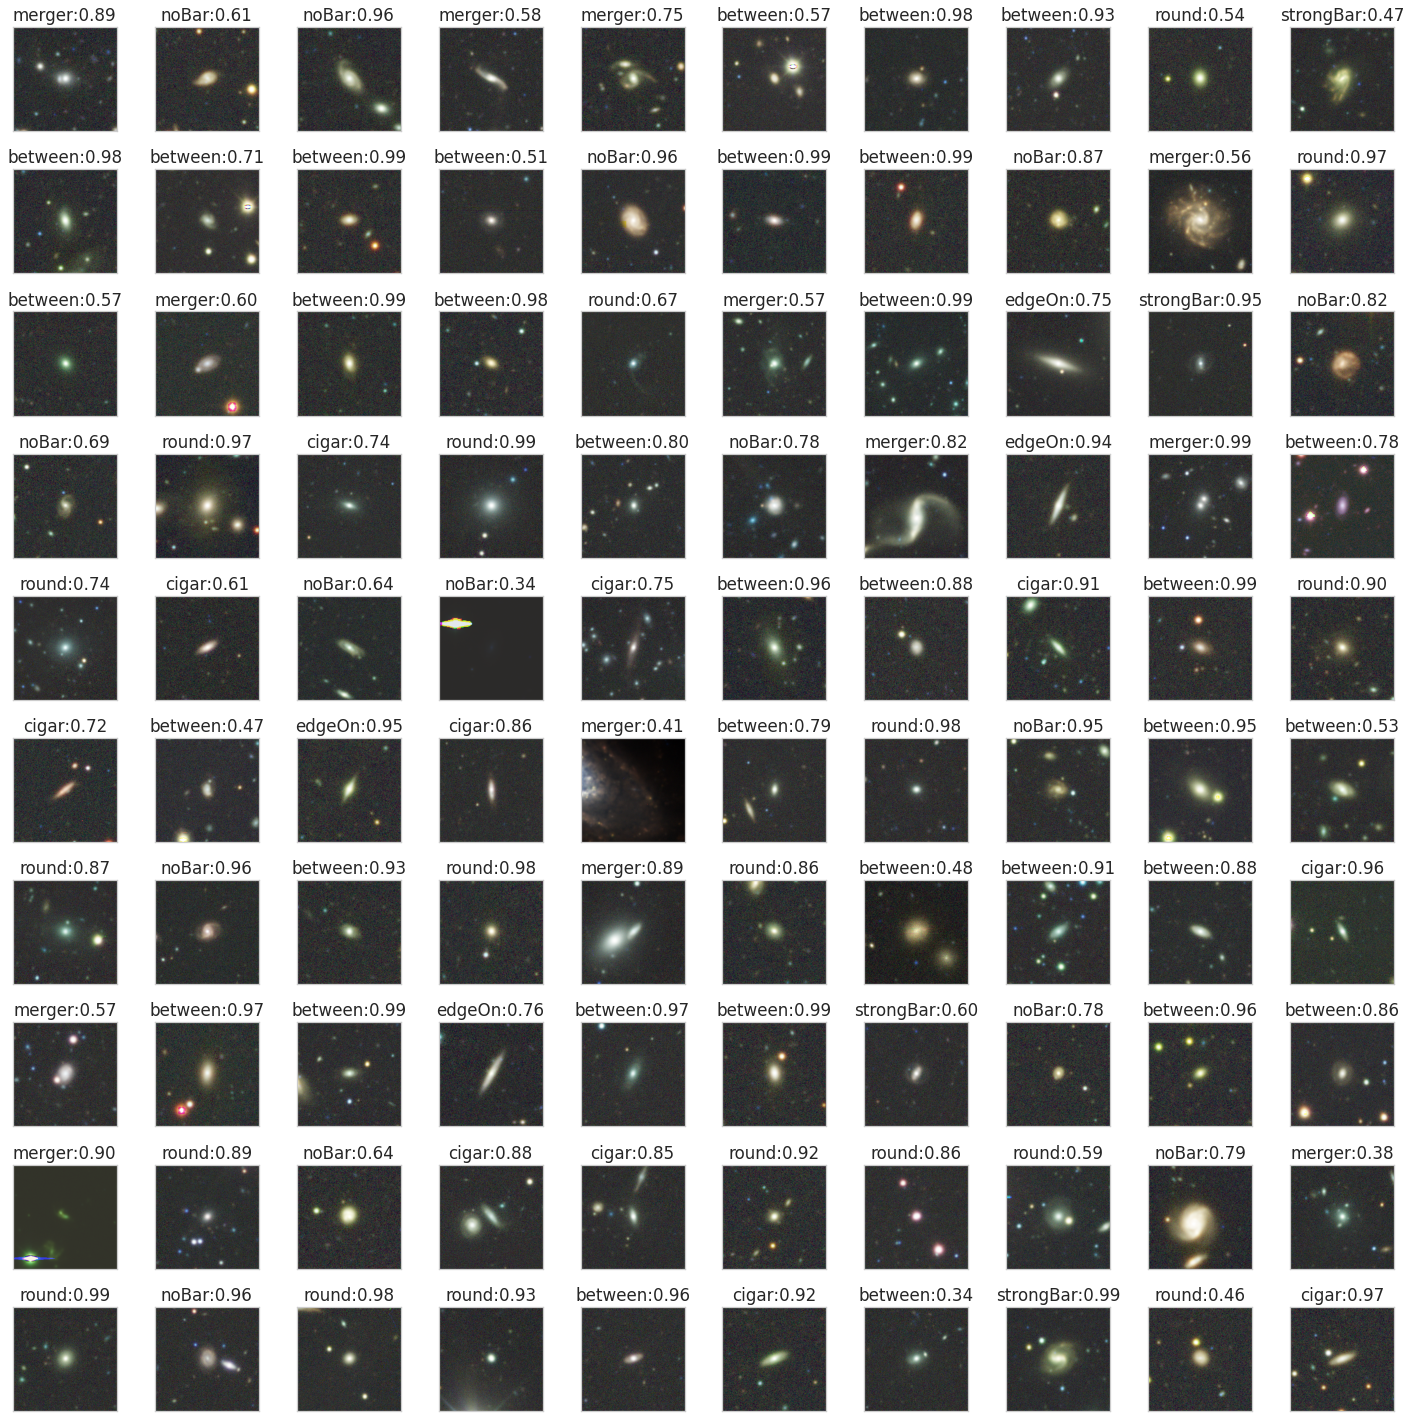

In [40]:
plt.figure(figsize=(20, 20))
begin = 300303
t = {0:"merger", 1:"round", 2:"between", 3:"cigar", 4:"edgeOn", 5:"noBar", 6:"strongBar"}
for i in range(begin, begin + 100):
    ax = plt.subplot(10, 10, i + 1 - begin)
    img = load_img(DATA_PATH + input[i][2])
    plt.imshow(chw2hwc(img))
    plt.xticks([])
    plt.yticks([])
    a, b = input[i][-1].split("\n")[0].split(".")
    prob = a + "." + b[:2]
    ax.set_title(t[int(input[i][-2])] + ":" + prob)
plt.tight_layout()
plt.show()